In [1]:
import pandas as pd
from analyserlib import distributionanalyzer as da
from analyserlib import usageanalyzer as ua
import os.path

# Retrieving Azure public traces as an example baseline

## Azure vm description (mandatory)

We provide two retrieving methods : from Azure Blob Storage (loaded data will be lost at notebook shutdown) or from disk (if you already downloaded the traces)

- From Azure Blob Storage

In [ ]:
from io import BytesIO
from urllib.request import urlopen
import gzip

print("Retrieving Azure public vm description dataset")
url = "https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vmtable/vmtable.csv.gz"
import urllib.request
with urllib.request.urlopen(url) as response:
    with gzip.GzipFile(fileobj=response) as uncompressed:
        file_content = uncompressed.read()
        
headers=['vmid','subscriptionid','deploymentid','vmcreated', 'vmdeleted', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcategory', 'vmcorecount', 'vmmemory']
trace_df = pd.read_csv(BytesIO(file_content), header=None, index_col=False,names=headers,delimiter=',')

print("Downloading and reading of vm description traces completed successfully!")

- From disk (adapt the path)

In [2]:
traces_path = '/usr/local/src/azure/data/vmtable.csv'

headers=['vmid','subscriptionid','deploymentid','vmcreated', 'vmdeleted', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcategory', 'vmcorecount', 'vmmemory']
trace_df = pd.read_csv(traces_path, header=None, index_col=False,names=headers,delimiter=',')

print("Reading of vm description traces completed successfully!")

Reading of vm description traces completed successfully!


In [ ]:
trace_df.head()

## Azure CPU traces (optional, only needed for periodicity ratio)

To compute cpu usage peridiocity, we need to load the Azure cpu traces dataset  <br>Due to memory constraints, we only retrieve part of this dataset. 32GB are however required to load 48h of traces. If you cannot meet this 32GB requirement, you can initialize a 0 periodicity ratio later in the notebook

- from Azure Blob Storage (not recommended, very slow)

In [ ]:
from io import BytesIO
from urllib.request import urlopen
import gzip
print("Retrieving Azure public cpu traces dataset")

url_begin = "https://azurecloudpublicdataset.blob.core.windows.net/azurepublicdataset/trace_data/vm_cpu_readings/vm_cpu_readings-file-"
url_end = "-of-125.csv.gz"
cpu_headers=['timestamp','vmid','cpu_min','cpu_max','cpu_avg']
frames = list()

for i in range(1,11):
    full_url = url_begin + str(i) + url_end
    print("Loading url", full_url)
    with urllib.request.urlopen(full_url) as response:
        with gzip.GzipFile(fileobj=response) as uncompressed:
            file_content = uncompressed.read()
            frames.append(pd.read_csv(BytesIO(file_content), header=None, index_col=False,names=cpu_headers,delimiter=','))
        
cpu_trace_df = pd.concat(frames)
print("Downloading and reading of cpu traces completed successfully!")

- Load cpu traces from disk (recommended) (adapt the path)

In [3]:
path_begin = '/usr/local/src/azure/data/vm_cpu_readings-file-'
path_end = '-of-125.csv'

cpu_headers=['timestamp','vmid','cpu_min','cpu_max','cpu_avg']
frames = list()

for i in range(1,11):
    full_path = path_begin + str(i) + path_end
    print("Loading file", full_path)
    frames.append(pd.read_csv(full_path, header=None, index_col=False,names=cpu_headers,delimiter=','))

cpu_trace_df = pd.concat(frames)
print("Reading of cpu traces completed successfully!")

Loading file /usr/local/src/azure/data/vm_cpu_readings-file-1-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-2-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-3-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-4-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-5-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-6-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-7-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-8-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-9-of-125.csv
Loading file /usr/local/src/azure/data/vm_cpu_readings-file-10-of-125.csv
Reading of cpu traces completed successfully!


In [ ]:
cpu_trace_df.head()

# CloudFactory : Build a distribution scenario

Instead ov naively counting all VMs in dataset, we compute VM flavor distribution for multiple timeslices. This avoid results to be biaised by low-lifetime VMs. You can configure slice duration (`timestamp_step`), begin of range (`timestamp_begin`, if None, minimal value observed in `col_vm_created` will be used) and end of range (`timestamp_end`, if None, maximum value observed in `col_vm_created` will be used)

In [4]:
timestamp_step = 3600 # 1 hour
timestamp_begin = None
timestamp_end = None 

col_flavor_cpu='vmcorecount' #column name in your dataset
col_flavor_mem='vmmemory' #column name in your dataset
col_vm_created='vmcreated' #column name in your dataset
col_vm_deleted='vmdeleted' #column name in your dataset

In [5]:
df_cpu, df_mem = da.get_cpu_and_mem_average_distribution(trace_df,
                        timestamp_begin=timestamp_begin, timestamp_end=timestamp_end, timestamp_step=timestamp_step,
                        col_flavor_cpu=col_flavor_cpu, col_flavor_mem=col_flavor_mem, 
                        col_vm_created=col_vm_created, col_vm_deleted=col_vm_deleted)

In [ ]:
print("CPU distribution observed:")
print(df_cpu)

In [ ]:
print("Memory distribution observed:")
print(df_mem)

VM distribution analysis is now completed. We write associated distribution scenario

In [6]:
output_file="scenario-vm-distribution.yml"
if not os.path.exists(output_file):
    da.convert_distribution_to_scenario(df_cpu, df_mem, 
                                        col_flavor_cpu='vmcorecount', col_flavor_mem='vmmemory', #columns name in your dataset
                                        output_file=output_file)
    print("Scenario written to", output_file)    
else:
    print("File already exists! Abording")

Scenario written to scenario-vm-distribution.yml


In [ ]:
print("Reading generated distribution as yaml file")
with open(output_file) as f:
    print(f.read())

# CloudFactory : Build a usage scenario

We now compute typical VM usage by building profile types. The number of profile to be deducted is configurable. These profiles are then completed in the following cells with various ratio used by CloudFactory

In [7]:
number_of_profile=4
# We use a kmean classification to compute bounds with requested number of profile
usage_profiles, trace_df_labeled = ua.build_n_scenario(trace_df, number_of_profile,
                                                       col_cpu_avg='avgcpu', col_cpu_per='p95maxcpu') #columns name in your dataset
usage_profiles.head(n=number_of_profile)

,label,count,freq,bound_avg_lower,bound_avg_higher,bound_per_lower,bound_per_higher
1,1,573265,0.28,0.0,25.9,0.0,31.2
3,3,423606,0.21,0.1,51.9,26.0,70.2
0,0,726088,0.36,0.2,33.3,66.6,100.0
2,2,290808,0.14,29.3,100.0,52.1,100.0


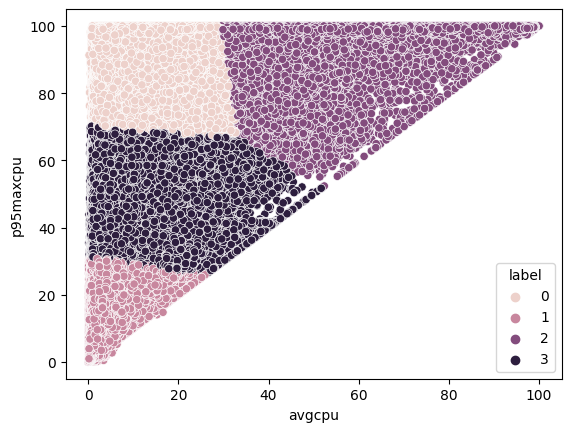

In [19]:
# Display graphically computed profiles (optional, time consuming)
import seaborn as sns
g = sns.scatterplot(data=trace_df_labeled, x='avgcpu', y='p95maxcpu', hue='label')

In [8]:
scope_duration = 24*3600 # we build arrival/departure ratios considering 24h windows
ua.build_arrival_and_departure_rates_per_label(usage_profiles, trace_df_labeled, 
                                               col_vm_created='vmcreated', col_vm_deleted='vmdeleted', #columns name in your dataset
                                               scope_duration=scope_duration)
usage_profiles.head(n=number_of_profile)

,label,count,freq,bound_avg_lower,bound_avg_higher,bound_per_lower,bound_per_higher,ratio_arriving,ratio_leaving
1,1,573265,0.28,0.0,25.9,0.0,31.2,0.15,0.15
3,3,423606,0.21,0.1,51.9,26.0,70.2,0.32,0.32
0,0,726088,0.36,0.2,33.3,66.6,100.0,0.60,0.60
2,2,290808,0.14,29.3,100.0,52.1,100.0,0.57,0.57


If you didn't load the Azure cpu traces dataset, you can initialize a 0 periodicity ratio using the following cell

In [ ]:
usage_profiles["ratio_periodicity"] = usage_profiles.apply(lambda x : 0.0, axis=1)
usage_profiles.head(n=number_of_profile)

If you did load the Azure cpu traces dataset, you can compute periodicity ratio using following cells

In [9]:
timestamp_per_hour = 12 # number of measure in one hour. Azure used 5mn delay, so 12 measures per hour
detect_periodicity_on_hour = 12 # we are interested in 12h periodicity
lifetime_condition = 3600*48 # VMs must have lived for at least 48h to be considered as periodic
max_number_of_tests = 500 # speed up parameter, set to -np.inf to disable
set_of_ids_in_cpu_traces = set(cpu_trace_df["vmid"].unique()) # used to link cpu and vm datasets. Time consuming

In [ ]:
ua.build_periodicity_rate_per_label(usage_profiles, trace_df_labeled, cpu_trace_df,
                                timestamp_per_hour=timestamp_per_hour,
                                detect_periodicity_on_hour=detect_periodicity_on_hour,
                                lifetime_condition=lifetime_condition,
                                max_number_of_tests=max_number_of_tests,
                                set_of_ids_in_cpu_traces=set_of_ids_in_cpu_traces,
                                col_vm_created='vmcreated', col_vm_deleted='vmdeleted', #columns name in your dataset
                                col_vm_id='vmid', col_vm_cpu='cpu_avg') #columns name in your dataset
usage_profiles.head()

Usage profiles are now completed. We write associated usage scenario

In [11]:
output_file="scenario-vm-usage.yml"
if not os.path.exists(output_file):
    ua.convert_usage_to_scenario(usage_profiles, output_file=output_file)
    print("Scenario written to", output_file)    
else:
    print("File already exists! Abording")

Scenario written to scenario-vm-usage.yml


In [ ]:
print("Reading generated usage as yaml file")
with open(output_file) as f:
    print(f.read())